In [11]:
import numpy as np
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from scipy.stats import logistic
import itertools as it
    
from typing import List, Tuple, Any



In [12]:
# # Binary neural network and dataset generation 

# sigmoid function
def sig(x):
  return 1 / (1 +  np.exp(-x))


def nonlinear(spin,x):
    if spin == 1:
        return sig(x)
    elif spin == -1: 
        return np.maximum(x,0.0)
    

# Forward pass of a le neural network with a single output (two classes). With search over which nonlinearity 

def NN(parameters,Nhid,d_out,x):
    d_in = x.shape[1]
    c = d_in*Nhid
    parameters.shape  
    nonl = parameters[parameters.shape[0]-1] # which nonlinearity
    W1 = np.reshape(parameters[0:c],[d_in,Nhid])
    #bias1 = np.reshape(parameters[0:c],[d_in,Nhid])  
    W2  = np.reshape(parameters[c:c+Nhid*d_out],[Nhid,d_out])
    b_2 = np.reshape(parameters[c+Nhid*d_out: c+Nhid*d_out+d_out],[d_out])
    b_1 = np.reshape(parameters[c+Nhid*d_out+d_out:c+Nhid*d_out+d_out+Nhid],[Nhid])
    #print("shapes x,W1,W2,b_2",x.shape,W1.shape,W2.shape,b_2.shape)
    #print(xx.shape) 
    aa = np.matmul(x,W1)+b_1
    #print(nonl,aa,nonlinear(nonl,aa),W2)
    out = logistic.cdf(np.matmul(nonlinear(nonl,aa),W2)+b_2)
    return out

# Forward pass logistic regression
def NN_l(parameters,Nhid,d_out,x):
    d_in = x.shape[1]
    c = d_in*d_out
    W1 = np.reshape(parameters[0:c],[d_in,d_out])
    b_1 = np.reshape(parameters[c:c+d_out],[d_out])
    #print("shapes x,W1,W2,b_2",x.shape,W1.shape,W2.shape,b_2.shape)
    #print(xx.shape) 
    out = sig(np.matmul(x,W1)+b_1)
    return out

# grid to plot 
def getgrid(xmax,xmin,step):
    xx = np.arange(xmin, xmax, step)
    #print(xx.shape) 
    points = np.zeros((xx.shape[0]*xx.shape[0],2))
    #print(points)
    k=0
    for i in range(xx.shape[0]):
        for j in range(xx.shape[0]):
            points[k,0]=xx[i]
            points[k,1]=xx[j]
            k=k+1
    return  points

# sample a dataset of a mixture of 2 2-dimensinal gaussians with mu1 cov1, mu2 cov2 means and covariances
def generate(Ns,m1,c1,m21,m22,m23,c21,c22,c23,p1,p21,p22):
    r = np.random.choice([0,1], Ns, p=[p1,1.0-p1])
    class1 = np.count_nonzero(r)
    class2 = Ns - class1
    #print(class1,class2)
    labels = class1*[0]
    labels.extend(class2*[1])

    # samples from class 1
    x1,y1 = np.random.multivariate_normal(m1, c1,class1 ).T
    samples1 = np.vstack((x1,y1)).T
    
    #samples from class II 
    
    r = np.random.choice([0,1,2], class2, p=[p21,p22,1.0-(p21+p22)])
    N1 = np.count_nonzero(r == 0)
    N2 = np.count_nonzero(r == 1)
    N3 = np.count_nonzero(r == 2)
    print("counting",N1+N2+N3,class2,class1,N1+N2+N3+class1)
    
    x21,y21  = np.random.multivariate_normal(m21, c21,N1 ).T
    x22,y22  = np.random.multivariate_normal(m22, c22,N2 ).T
    x23,y23  = np.random.multivariate_normal(m23, c23,N3 ).T
    samples21 = np.vstack((x21,y21)).T
    samples22 = np.vstack((x22,y22)).T 
    samples23 = np.vstack((x23,y23)).T
    
    samples  = np.vstack((samples1,samples21,samples22,samples23))
    return samples,labels





counting 5055 5055 4945 10000


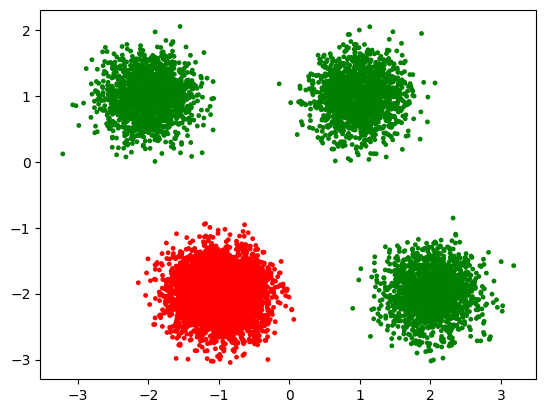

In [13]:
# ************* Data set generation *****************

# Sample the distribution p(x,y) = sum_{k} p_{k} P(x,y| k )
# P(x,y|k=1) = N(x,y| m1,c1) Gaussian with mu = m1 and covariance = c1
# P(x,y|k=2) =  p_{2,1} N(x,y| m21,c21) +  p_{2,2} N(x,y| m22,c22)+ p_{2,3} N(x,y| m23,c23)
# the labels correspond to k = 1 or 2 

# Properties of Gaussian #1
m1 = [-1, -2] # mean
c1 = 0.1*np.array([[1.0, 0], [0, 1.0]]) # covariance matrix 

# Properties of Gaussian #21
m21 = [-2, 1]
c21 = 0.1*np.array([[1.0, 0], [0, 1.0]]);

# Properties of Gaussian #22
m22 = [1, 1]
c22 = 0.1*np.array([[1.0, 0], [0, 1.0]]);

# Properties of Gaussian #23
m23 = [2, -2]
c23 = 0.1*np.array([[1.0, 0], [0, 1.0]]);

p21=0.33333
p22=0.33333


p1 = 0.5

# size of the training set
Ns = 10000
x,y   = generate(Ns,m1,c1,m21,m22,m23,c21,c22,c23,p1,p21,p22)
colormap = np.array(['r', 'g', 'b'])
plt.scatter(x[:,0], x[:,1], c=colormap[y],s=6,zorder=2)




In [14]:
#****** Defining the Neural network **************

Nhid = 4  # Number of hidden dimensions
d_out = 1 # dimension of output (1 for binary classification here)
d_in = 2  # Dimension of input 

#             W1          W2           b_2    b_1    Which nonlinear function 
Nparameters = Nhid*d_in + Nhid*d_out + d_out+ Nhid + 1 


print("number of parameters ",Nparameters)

# all the possible "neural nets"
bits = (np.array(list(it.product(range(2), repeat = Nparameters )),dtype=np.int8))
a = (2*(np.array(list(it.product(range(2), repeat = Nparameters )),dtype=np.int8)) - 1)
#print(bits)



number of parameters  18


In [ ]:
#*********** brute force finding the neural network with the lowest cost function **************
out = NN(a[0],Nhid,d_out,x)
loss = np.mean((out.reshape(-1) - np.array(y).reshape(-1))**2)
Weights = a[0]
print(bits[0],loss)
C = []
C.append(loss)

for i in range(1,a.shape[0]):
    #out = NN(a[i],Nhid,d_out,x) 
    out = NN(a[i],Nhid,d_out,x)
    loss_new = np.mean((out.reshape(-1) - np.array(y).reshape(-1))**2)
    C.append(loss_new)
    #print(loss_new)
    #print(loss_new)
    if loss_new<loss:
        #print(loss,loss_new)  
        loss = loss_new
        Weights = a[i]

C = np.array(C)        
        

print(loss,Weights)
plt.plot(C)
plt.xlabel("configuration index")
plt.ylabel("Cost function")






[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0.2928550027335314


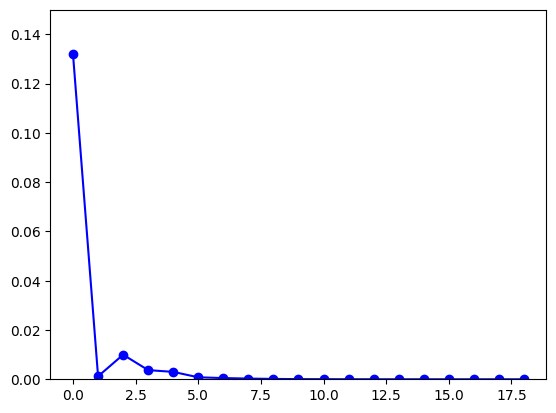

In [8]:
 # Basis
I = np.array([1, 1]);
Z = np.array([1,-1]); 
M = np.zeros((2,2))

M[0,:] = I
M[1,:] = Z 

N = Nparameters
psum = np.zeros((Nparameters*[2]))
d = 2
Ct = np.reshape(np.reshape(C,(-1)),d**N) 

for k in range(N):
    
    Ct = np.tensordot(M,Ct.reshape(d**k, d, d**(N - 1 - k)),axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)



Ct = Ct/2**N

weight = np.zeros(Nparameters+1)

for k in range(2**N):
    
    indexw = np.sum(bits[k])
    weight[indexw] = weight[indexw] + Ct[k]**2

plt.plot(weight,'bo',ls='-')
plt.ylim((0,0.15))

np.savetxt("Ct_18parameters.txt",weight)
